Download the support file for IS computation.

In [ ]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw': 'inception_score.py',
'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE': 'test_case_VAE.zip',
'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV': 'test_case_GAN.zip'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q test_case_VAE.zip
! unzip -q test_case_GAN.zip

In [ ]:
! unzip -q cyclegan_files.zip

# VAE
### Load data for VAE


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

## Model Definition

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, zdim):
    super(VAE,self).__init__()
   
    self.zdim      = zdim
    self.fc1       = nn.Sequential(nn.Linear(784,400), nn.ReLU(inplace=False)) 
    self.fc2_mean  = nn.Sequential(nn.Linear(400,zdim), nn.ReLU(inplace = False))
    self.fc2_var   = nn.Sequential(nn.Linear(400,zdim), nn.ReLU(inplace =False))

    self.fc3 = nn.Sequential(nn.Linear(zdim,400), nn.ReLU(inplace = False))
    self.fc4 = nn.Sequential(nn.Linear(400, 784), nn.Sigmoid())
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    
    
  def encode(self, X):
    out  = self.fc1(X)
    mean = self.fc2_mean(out)
    log_var  = self.fc2_var(out) 

    return mean, log_var

  def decode(self, X):
   
    X = self.fc3(X)
    X = self.fc4(X)

    return X

  def reparameterization(self, mean, log_var):
    
    std = torch.exp(0.5*log_var)  
    eps = torch.randn_like(std, device= self.device)
    z = mean + eps * std 

    return z

  def forward(self, X):
    X = X.view(-1,784)
    mean, log_var = self.encode(X)
    z = self.reparameterization(mean, log_var)
    return self.decode(z), mean, log_var

## VAE Train

### VAE Reconstruction Evaluation 

In [ ]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
    '''
    Argms: 
    Input:
        model: VAE model
        test_loader: Fashion-MNIST test_loader
    Output:
        avg_err: MSE 
    '''
    model.eval()
   
    loss = nn.BCELoss(reduction='sum')
    
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
        output, mean, log_var = model.forward(data)
        
        idx_counter+=data.shape[0] # sum up the number of images in test_loader

        output_flat = output.view(-1)
        recon_err += loss(output_flat, data.view(-1)) 
        
    avg_err = recon_err/idx_counter
    return avg_err

### Reconstruction error + KL divergence losses in VAE

In [ ]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
   
    KLD      = 0.5*torch.sum(torch.exp(log_var) + mu**2 + -1 - log_var)
    BCE_loss = nn.BCELoss(reduction='sum')
    BCE = BCE_loss(recon_x.view(-1), x.view(-1)) 
    totalloss = BCE + KLD

    return totalloss, BCE, KLD

### VAE Training

Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 549.307695 	Recon_err: 532.10791015625
Train Epoch: 1 17% 	Loss: 327.772148 	Recon_err: 303.38623046875
Train Epoch: 1 33% 	Loss: 307.895977 	Recon_err: 281.3267822265625
Train Epoch: 1 50% 	Loss: 296.377891 	Recon_err: 275.3370361328125
Train Epoch: 1 67% 	Loss: 287.264063 	Recon_err: 270.4334411621094
Train Epoch: 1 83% 	Loss: 289.438867 	Recon_err: 269.0438232421875
Epoch: 1 Train loss: 303.9946
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 276.896270 	Recon_err: 266.63262939453125
Train Epoch: 2 17% 	Loss: 282.772207 	Recon_err: 265.0445556640625
Train Epoch: 2 33% 	Loss: 274.496484 	Recon_err: 264.0239562988281
Train Epoch: 2 50% 	Loss: 294.394336 	Recon_err: 263.36712646484375
Train Epoch: 2 67% 	Loss: 285.513555 	Recon_err: 263.5557556152344
Train Epoch: 2 83% 	Loss: 299.206758 	Recon_err: 260.8161315917969
Epoch: 2 Train loss: 280.6848
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 283.082227 	Recon_err: 260.91693115234375
Train Epoc

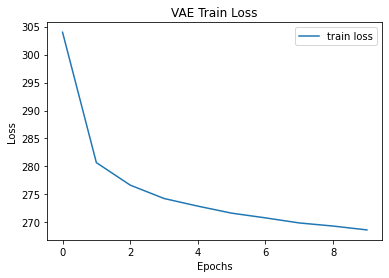

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Z dimension
ZDIM = 100

#Initialize VAE
vae = VAE(ZDIM).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs 
num_epochs = 10
import pdb
train_loss_list = []
bce_loss_list = []
kld_loss_list = []
orig_image_list = []
recon_image_list = []
reconst_error = []


# Define Train loop 
def train(epochs, train_loader, test_loader):

  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      bce_loss = 0
      kld_loss = 0
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()
          recon_batch, mean, log_var = vae.forward(data)

          loss, bce, kld = loss_function(recon_batch, data, mean, log_var)
          
          loss.backward()
          train_loss += loss.item()
          bce_loss += bce.item()
          kld_loss += kld.item()
          optimizer.step()

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          del data; del recon_batch; del mean; del log_var    
          
      train_loss_list.append(train_loss / len(train_loader.dataset))
      bce_loss_list.append(bce_loss / len(train_loader.dataset))
      kld_loss_list.append(kld_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step() 

    #   recon_err = reconstruction_error(vae, test_loader)
    #   print('Epoch: {} Reconstruction Error: {:.4f}'.format(epoch+1, recon_err))
      if epoch%5==0:
        with torch.no_grad():
          
            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

  # save the training checkpoint
  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/drive/MyDrive/HW5/models/vae_{}.pt'.format(epochs))
# Run Train loop
train(num_epochs, train_loader, test_loader)

# Plot Train loss
plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Qualitative Visualisations

### VAE Testing

torch.Size([36, 784])


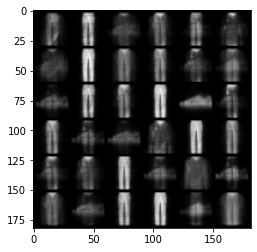

In [ ]:
# Test VAE on a random sample and display on 6X6 grid
grid_size = 6 

vae.eval()
with torch.no_grad():
  x_batch =torch.randn(6*6, ZDIM)
  recon_batch = vae.decode(x_batch.to(device))
  print(recon_batch.shape)
  reconstructed_img = vutils.make_grid(recon_batch.view(recon_batch.shape[0],1,28,28).cpu(), nrow=6 ,padding=2, normalize=True)
  plt.imshow(reconstructed_img.numpy().transpose(1,2,0))
  plt.show()

### Visualize the original vs reconstructed images

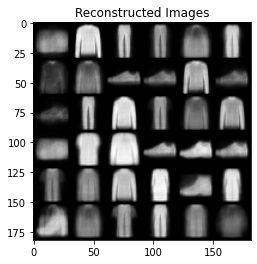

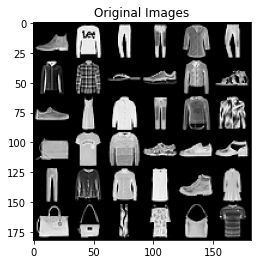

In [ ]:
# Visualise the original vs reconstructed images
# Input the 36 images in Fashion-MNIST to VAE network 
# and display reconstructed output on 6X6 grid

with torch.no_grad():
  
  for i, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data[:36]
    output, mean, log_var = vae.forward(data)
    break

  reconstructed_img = vutils.make_grid(output.view(output.shape[0],1,28,28).cpu(), nrow=6 ,padding=2, normalize=True)
  original_img = vutils.make_grid(data.view(data.shape[0],1,28,28).cpu(), nrow=6 ,padding=2, normalize=True)

  plt.figure()
  plt.imshow(reconstructed_img.numpy().transpose(1,2,0))
  plt.title("Reconstructed Images")
  plt.show()

  plt.figure()
  plt.imshow(original_img.numpy().transpose(1,2,0))
  plt.title("Original Images")
  plt.show()


## Quantitative Evaluation

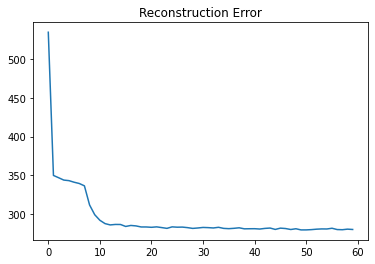

Final Reconstruction Error is : 280


In [ ]:
plt.plot(reconst_error)
plt.title("Reconstruction Error")
plt.show()
print("Final Reconstruction Error is : %d" %(reconst_error[-1]))


Visualizing train loss, BCE loss, and KLD loss

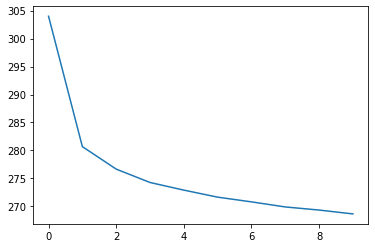

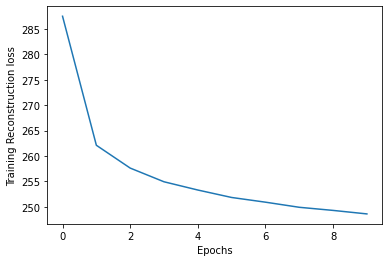

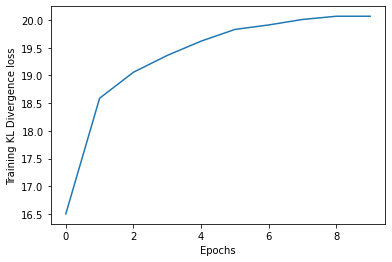

In [ ]:
plt.figure(0)
plt.plot(train_loss_list)

plt.figure(1)
plt.plot(bce_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Training Reconstruction loss')
plt.savefig('BCE Loss')
plt.show()

plt.figure(2)
plt.plot(kld_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Training KL Divergence loss')
plt.savefig("KLD loss")
plt.show()

### VAE IS score

The following block create 2 torch dataset.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_saved = torch.load('/content/vae_{}.pt'.format(num_epochs))
model_vae = VAE(ZDIM).cuda()
model_vae.load_state_dict(model_saved['vae'])

# Prepare the torch dataset
evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    model_vae.eval()
    image = data[0].cuda()
    # print(image.shape)
    gen_image, _, _ = model_vae(image)

    # print(gen_image.shape)
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
    # print(gen_image.shape)
    
    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)

        
    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))


#### IS API
Here IS API is used to compute IS score

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

(4.134691910735765, 0.0)
generated images IS_score:
(2.33142502700424, 0.0)


# GAN
### Load data for GAN


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batchsize of dataset
batch_size = 128

# Load STL-10 Dataset
gan_train_dataset = datasets.STL10(root='./stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./stl10_data/stl10_binary.tar.gz to ./stl10_data/


## Model Definition

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        self.layer = nn.Sequential(nn.ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False),
                              nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.Tanh())
        

    def forward(self, input):
        return self.layer(input)


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.layer = nn.Sequential(nn.Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
                              nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False),
                              nn.Sigmoid())
    
    def forward(self, input):
        return self.layer(input)

## GAN Training

### GAN loss

In [ ]:
import torch


fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')




def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):

    # return total loss_D and fake images
    real_out = D(real)
    loss_real  = criterion(real_out.view(-1),Valid_label)

    fake = G(noise)
    fake_out    = D(fake.detach())
    loss_fake   = criterion(fake_out.view(-1),Fake_label)

    loss_D = loss_fake+loss_real

    return loss_D, fake

def loss_generator(netD, fake, Valid_label, criterion):

    fake_out=netD(fake)
    loss_G = criterion(fake_out.view(-1),Valid_label)

    return loss_G


loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
torch.save(loss_D, 'test_case_GAN/loss_D.pt')
loss_G = loss_generator(netD, fake, Valid_label, criterion)
torch.save(loss_G, 'test_case_GAN/loss_G.pt')



test_loss_D = torch.load('test_case_GAN/loss_D.pt')
test_loss_G = torch.load('test_case_GAN/loss_G.pt')

print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())


test case loss_D: 1.3626351356506348
computed loss_D: 1.3626351356506348
test case loss_G: 0.7321602702140808
computed loss_G: 0.7321602702140808


### Training block

[0/100][0/40]	Loss_D: 1.3900	Loss_G: 0.8109	
[1/100][0/40]	Loss_D: 0.0616	Loss_G: 3.8322	
[2/100][0/40]	Loss_D: 0.3672	Loss_G: 4.8418	
[3/100][0/40]	Loss_D: 0.0675	Loss_G: 4.6091	
[4/100][0/40]	Loss_D: 0.0715	Loss_G: 5.5488	
[5/100][0/40]	Loss_D: 0.1369	Loss_G: 5.6645	
[6/100][0/40]	Loss_D: 0.3534	Loss_G: 3.1298	
[7/100][0/40]	Loss_D: 0.7323	Loss_G: 3.2581	
[8/100][0/40]	Loss_D: 0.4155	Loss_G: 3.0681	
[9/100][0/40]	Loss_D: 0.3014	Loss_G: 5.4529	
[10/100][0/40]	Loss_D: 0.5216	Loss_G: 4.8765	
[11/100][0/40]	Loss_D: 0.6325	Loss_G: 2.3713	
[12/100][0/40]	Loss_D: 0.5535	Loss_G: 4.8536	
[13/100][0/40]	Loss_D: 0.1983	Loss_G: 3.0826	
[14/100][0/40]	Loss_D: 0.2563	Loss_G: 5.1890	
[15/100][0/40]	Loss_D: 0.3440	Loss_G: 3.7013	
[16/100][0/40]	Loss_D: 0.5927	Loss_G: 4.2262	
[17/100][0/40]	Loss_D: 0.6319	Loss_G: 5.0024	
[18/100][0/40]	Loss_D: 0.8869	Loss_G: 6.0562	
[19/100][0/40]	Loss_D: 0.5168	Loss_G: 3.5290	
[20/100][0/40]	Loss_D: 1.8417	Loss_G: 5.2392	
[21/100][0/40]	Loss_D: 0.4852	Loss_G: 3.3870

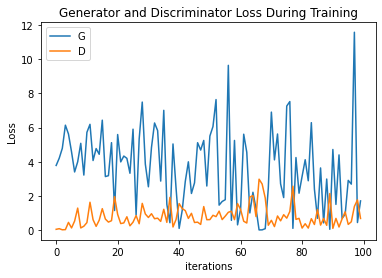

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss().cuda()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
start_epoch = 0


# GAN Training Loop
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Function to compute discriminator loss
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)

        # pdb.set_trace()
        fake = fake.cuda()
        loss_D.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Function to compute generator loss
        loss_G = loss_generator(netD, fake, Valid_label, criterion)
        # Calculate gradients for G
        loss_G.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))


        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    if epoch%10==0:
        checkpoint = {'netG': netG.state_dict(),
          'netD': netD.state_dict()}
        torch.save(checkpoint, '/content/drive/MyDrive/gan_{}.pt'.format(epoch))
    
    # Save Losses for plotting later
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

torch.save({'netG': netG.state_dict(),
          'netD': netD.state_dict()},
          '/content/drive/MyDrive/gan_{}.pt'.format(epoch))
        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Qualitative Visualisations

### GAN Testing

torch.Size([36, 3, 64, 64])


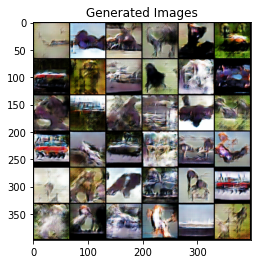

In [ ]:
# Test GAN on a random sample and display on 6X6 grid
# checkpoint  = torch.load('/content/drive/MyDrive/HW5/gan_{}.pt'.format(99))
# netG.load_state_dict(checkpoint['netG'])
# netD.load_state_dict(checkpoint['netD'])
################################
with torch.no_grad():
  noise  = torch.randn(36, nz, 1, 1, device=device)
  images = netG(noise)
  print(images.shape)
  image_out = vutils.make_grid(images, nrow=6 ,padding=2, normalize=True)
  plt.figure()
  plt.imshow(image_out.cpu().numpy().transpose(1,2,0))
  plt.title("Generated Images")
  plt.show()
################################


### Visualisation at different epochs

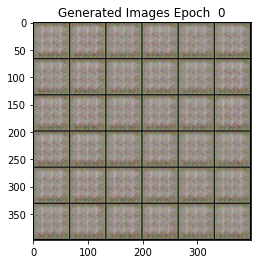

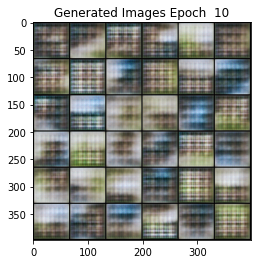

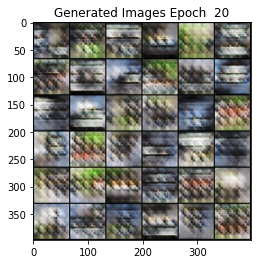

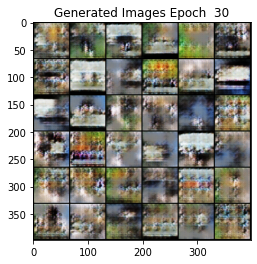

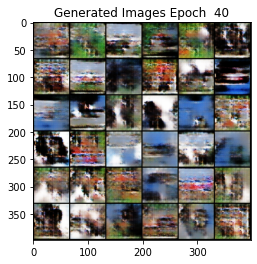

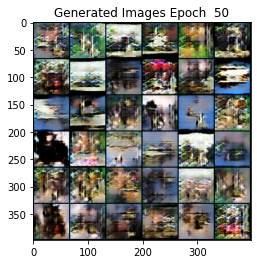

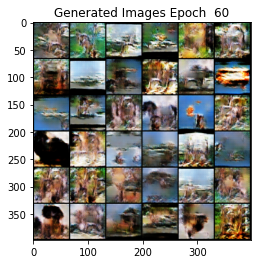

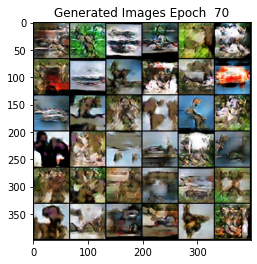

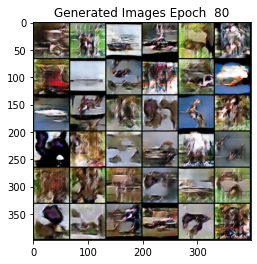

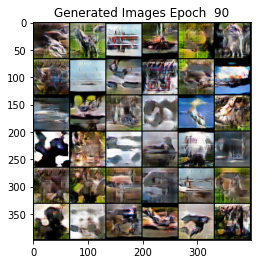

In [ ]:
# Plot GAN generated images at different epochs during training

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)
with torch.no_grad():
  noise  = torch.randn(36, nz, 1, 1, device=device)
  for i in range(10):
    checkpoint  = torch.load('/content/drive/MyDrive/HW5/gan_{}.pt'.format(i*10))
    netG.load_state_dict(checkpoint['netG'])
    netD.load_state_dict(checkpoint['netD'])
    images = netG(noise)
    image_out = vutils.make_grid(images, nrow=6 ,padding=2, normalize=True)
    plt.figure()
    plt.imshow(image_out.cpu().numpy().transpose(1,2,0))
    plt.title("Generated Images Epoch  "+ str(i*10))
    plt.savefig('/content/drive/MyDrive/HW5/Generated Images_{}.png'.format(i*10))
    plt.show()
    


## Quantitative Evaluation

In [ ]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='./stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


### FID score for GAN


In [ ]:
! mkdir STL_10_fake STL_10_real_1 STL_10_real_2

Create the dataset to evaluate quantitative scores.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Load checkpoint
model_saved = torch.load('/content/drive/MyDrive/HW5/gan_99.pt')
netG = DCGAN_Generator()
netG.load_state_dict(model_saved['netG'])
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y



evaluate_num = 1000

# make the gen data set and folder
gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # print(fake_denorm.shape)
        gen_set.append(fake_denorm)
        
        # plt.imshow(np.transpose(vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True),(1,2,0)), animated=True)
        save_image(fake.squeeze(), './STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))

# make the real data set and folder
real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]
    # print(image.shape)
    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))


#### FID API

In [ ]:
! pip install pytorch-fid
! python -m pytorch_fid '/content/drive/MyDrive/STL_10_real_1' '/content/drive/MyDrive/STL_10_real_1' 
! python -m pytorch_fid '/content/drive/MyDrive/STL_10_real_1' '/content/drive/MyDrive/STL_10_real_2' 
! python -m pytorch_fid '/content/drive/MyDrive/STL_10_real_1' '/content/drive/MyDrive/STL_10_fake' 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:08<00:00, 11.7MB/s]
100% 20/20 [00:06<00:00,  3.03it/s]
100% 20/20 [00:04<00:00,  4.68it/s]
FID:  -2.2148069376726198e-05
/usr/local/lib/python3.8/dist-packages/torchvision/mod

### IS score for GAN

#### IS API

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for real data set 2:')
print(inception_score(real_dataset_2, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

(14.623438496656947, 0.0)
IS score for real data set 2:
(15.913449718671151, 0.0)
IS score for generated data set:
(2.5682676234445814, 0.0)
